In [1]:
using LinearAlgebra
using LimberJack
using CSV
using YAML
using JLD2
using PythonCall
using DataFrames
using NPZ
sacc = pyimport("sacc");

In [2]:
sacc_path = "../../PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path_wlwl = "data/DESY1/wlwl.yml"
sacc_wlwl = sacc.Sacc().load_fits(sacc_path)
yaml_wlwl = YAML.load_file(yaml_path_wlwl)
meta_wlwl, files_wlwl = make_data(sacc_wlwl, yaml_wlwl)

DESwl__0 DESwl__0 24
DESwl__0 DESwl__1 24
DESwl__0 DESwl__2 24
DESwl__0 DESwl__3 24
DESwl__1 DESwl__1 24
DESwl__1 DESwl__2 24
DESwl__1 DESwl__3 24
DESwl__2 DESwl__2 24
DESwl__2 DESwl__3 24
DESwl__3 DESwl__3 24


(LimberJack.Instructions(["DESwl__0", "DESwl__1", "DESwl__2", "DESwl__3"], Any[["DESwl__0", "DESwl__0"], ["DESwl__0", "DESwl__1"], ["DESwl__0", "DESwl__2"], ["DESwl__0", "DESwl__3"], ["DESwl__1", "DESwl__1"], ["DESwl__1", "DESwl__2"], ["DESwl__1", "DESwl__3"], ["DESwl__2", "DESwl__2"], ["DESwl__2", "DESwl__3"], ["DESwl__3", "DESwl__3"]], ["galaxy_shear", "galaxy_shear", "galaxy_shear", "galaxy_shear"], [0, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240], [2.4659965589802277e-9, 1.937338987992683e-9, 6.992765360481148e-10, -4.9611713239579213e-11, 7.913395793306234e-10, 2.025477514463439e-10, 2.937251108461027e-10, 2.5800941836058233e-10, 3.588061352802992e-10, 6.231168353367879e-10  …  4.737458899576856e-10, 8.27594560926968e-10, 5.318332277673948e-10, 3.860067333751191e-10, 4.674884118894536e-10, 3.737344096265107e-10, 8.676072775051082e-11, 2.8609099937088954e-10, 2.0381853638647756e-10, 1.2493271614464064e-10], [1.4706926451000433e-18 -9.21447582866358e-20 … -8.136848663034692e-24 -7.

In [3]:
sacc_path = "../../PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path_gcgc = "data/DESY1/gcgc.yml"
sacc_gcgc = sacc.Sacc().load_fits(sacc_path)
yaml_gcgc = YAML.load_file(yaml_path_gcgc)
meta_gcgc, files_gcgc = make_data(sacc_gcgc, yaml_gcgc)

DESgc__0 DESgc__0 5
DESgc__1 DESgc__1 8
DESgc__2 DESgc__2 10
DESgc__3 DESgc__3 11
DESgc__4 DESgc__4 13


(LimberJack.Instructions(["DESgc__0", "DESgc__1", "DESgc__2", "DESgc__3", "DESgc__4"], Any[["DESgc__0", "DESgc__0"], ["DESgc__1", "DESgc__1"], ["DESgc__2", "DESgc__2"], ["DESgc__3", "DESgc__3"], ["DESgc__4", "DESgc__4"]], ["galaxy_density", "galaxy_density", "galaxy_density", "galaxy_density", "galaxy_density"], [0, 5, 13, 23, 34, 47], [0.00019024248750512107, 7.391276663994371e-5, 4.261252890607883e-5, 2.22965965139283e-5, 2.176880112868429e-5, 8.240734039668606e-5, 8.421314587773898e-5, 2.6585137640401017e-5, 2.6033426315289483e-5, 1.6202481595102046e-5  …  1.720793463317388e-5, 1.876041365219758e-5, 1.1858834397319835e-5, 6.023987322753388e-6, 3.4894299563905405e-6, 7.420152296134288e-6, 4.729410691534381e-6, 4.317808418665961e-6, 4.736098712055406e-6, 2.545509196409628e-6], [3.503459378925734e-9 -2.6907237994012596e-10 … -1.8766243449428733e-32 -1.9859652134651026e-32; -2.6907237994012596e-10 2.4651642374142706e-10 … -4.810041560235908e-31 -4.501051455667023e-31; … ; -1.87662434494

In [4]:
sacc_path = "../../PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path_3x2 = "data/DESY1/gcgc_gcwl_wlwl.yml"
sacc_3x2 = sacc.Sacc().load_fits(sacc_path)
yaml_3x2 = YAML.load_file(yaml_path_3x2) 
meta_3x2, files_3x2 = make_data(sacc_3x2, yaml_3x2)

DESgc__0 DESgc__0 5
DESgc__1 DESgc__1 8
DESgc__2 DESgc__2 10
DESgc__3 DESgc__3 11
DESgc__4 DESgc__4 13
DESgc__0 DESwl__0 5
DESgc__0 DESwl__1 5
DESgc__0 DESwl__2 5
DESgc__0 DESwl__3 5
DESgc__1 DESwl__0 8
DESgc__1 DESwl__1 8
DESgc__1 DESwl__2 8
DESgc__1 DESwl__3 8
DESgc__2 DESwl__0 10
DESgc__2 DESwl__1 10
DESgc__2 DESwl__2 10
DESgc__2 DESwl__3 10
DESgc__3 DESwl__0 11
DESgc__3 DESwl__1 11
DESgc__3 DESwl__2 11
DESgc__3 DESwl__3 11
DESgc__4 DESwl__0 13
DESgc__4 DESwl__1 13
DESgc__4 DESwl__2 13
DESgc__4 DESwl__3 13
DESwl__0 DESwl__0 24
DESwl__0 DESwl__1 24
DESwl__0 DESwl__2 24
DESwl__0 DESwl__3 24
DESwl__1 DESwl__1 24
DESwl__1 DESwl__2 24
DESwl__1 DESwl__3 24
DESwl__2 DESwl__2 24
DESwl__2 DESwl__3 24
DESwl__3 DESwl__3 24


(LimberJack.Instructions(["DESgc__0", "DESgc__1", "DESgc__2", "DESgc__3", "DESgc__4", "DESwl__0", "DESwl__1", "DESwl__2", "DESwl__3"], Any[["DESgc__0", "DESgc__0"], ["DESgc__1", "DESgc__1"], ["DESgc__2", "DESgc__2"], ["DESgc__3", "DESgc__3"], ["DESgc__4", "DESgc__4"], ["DESgc__0", "DESwl__0"], ["DESgc__0", "DESwl__1"], ["DESgc__0", "DESwl__2"], ["DESgc__0", "DESwl__3"], ["DESgc__1", "DESwl__0"]  …  ["DESwl__0", "DESwl__0"], ["DESwl__0", "DESwl__1"], ["DESwl__0", "DESwl__2"], ["DESwl__0", "DESwl__3"], ["DESwl__1", "DESwl__1"], ["DESwl__1", "DESwl__2"], ["DESwl__1", "DESwl__3"], ["DESwl__2", "DESwl__2"], ["DESwl__2", "DESwl__3"], ["DESwl__3", "DESwl__3"]], ["galaxy_density", "galaxy_density", "galaxy_density", "galaxy_density", "galaxy_density", "galaxy_shear", "galaxy_shear", "galaxy_shear", "galaxy_shear"], [0, 5, 13, 23, 34, 47, 52, 57, 62, 67  …  259, 283, 307, 331, 355, 379, 403, 427, 451, 475], [0.00019024248750512107, 7.391276663994371e-5, 4.261252890607883e-5, 2.22965965139283e-5

### Data

In [ ]:
CSV.write("data/DESY1/data_wlwl.csv",
    Dict{String}{Vector}(
        "data" => meta_wlwl.data,
        "err" => sqrt.(diag(meta_wlwl.cov))))

CSV.write("data/DESY1/data_gcgc.csv",
    Dict{String}{Vector}(
        "data" => meta_gcgc.data,
        "err" => sqrt.(diag(meta_gcgc.cov))))
    
CSV.write("data/DESY1/data_3x2.csv",
    Dict{String}{Vector}(
        "data" => meta_3x2.data,
        "err" => sqrt.(diag(meta_3x2.cov))))

In [ ]:
delete!(files_wlwl, "nz_DESwl__0")
delete!(files_wlwl, "nz_DESwl__1")
delete!(files_wlwl, "nz_DESwl__2")
delete!(files_wlwl, "nz_DESwl__3")

delete!(files_gcgc, "nz_DESgc__0")
delete!(files_gcgc, "nz_DESgc__1")
delete!(files_gcgc, "nz_DESgc__2")
delete!(files_gcgc, "nz_DESgc__3")
delete!(files_gcgc, "nz_DESgc__4")

delete!(files_3x2, "nz_DESwl__0")
delete!(files_3x2, "nz_DESwl__1")
delete!(files_3x2, "nz_DESwl__2")
delete!(files_3x2, "nz_DESwl__3")
delete!(files_3x2, "nz_DESgc__0")
delete!(files_3x2, "nz_DESgc__1")
delete!(files_3x2, "nz_DESgc__2")
delete!(files_3x2, "nz_DESgc__3")
delete!(files_3x2, "nz_DESgc__4")

In [ ]:
npzwrite("data/DESY1/files_wlwl.npz", files_wlwl)
npzwrite("data/DESY1/files_gcgc.npz", files_gcgc)
npzwrite("data/DESY1/files_3x2.npz", files_3x2)

### Make Data

In [5]:
function model_wlwl(x; meta=meta_wlwl, files=files_wlwl)

    nuisances = Dict(
        "DESgc__0_b" => 1.484,
        "DESgc__1_b" => 1.805,
        "DESgc__2_b" => 1.776,
        "DESgc__3_b" => 2.168,
        "DESgc__4_b" => 2.23,
        "DESwl__0_m" => 0.018,
        "DESwl__1_m" => 0.014,
        "DESwl__2_m" => 0.01,
        "DESwl__3_m" => 0.004,
        "A_IA" => 0.294,
        "alpha_IA" => 0.378)
    
    cosmology = Cosmology(Ωm=x[1],  Ωb=x[2], h=x[3], ns=x[4], σ8=x[5],
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    theory = Theory(cosmology, meta, files; Nuisances=nuisances)
    d = theory .- meta.data
    xi2 = d'*meta.inv_cov*d
    return theory, xi2
end

function model_gcgc(x; meta=meta_gcgc, files=files_gcgc)

    nuisances = Dict(
        "DESgc__0_b" => 1.484,
        "DESgc__1_b" => 1.805,
        "DESgc__2_b" => 1.776,
        "DESgc__3_b" => 2.168,
        "DESgc__4_b" => 2.23,
        "DESwl__0_m" => 0.018,
        "DESwl__1_m" => 0.014,
        "DESwl__2_m" => 0.01,
        "DESwl__3_m" => 0.004,
        "A_IA" => 0.294,
        "alpha_IA" => 0.378)

    cosmology = Cosmology(Ωm=x[1],  Ωb=x[2], h=x[3], ns=x[4], σ8=x[5],
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    theory = Theory(cosmology, meta, files; Nuisances=nuisances)
    d = theory .- meta.data
    xi2 = d'*meta.inv_cov*d
    return theory, xi2
end

function model_3x2(x; meta=meta_3x2, files=files_3x2)

    nuisances = Dict(
        "DESgc__0_b" => 1.484,
        "DESgc__1_b" => 1.805,
        "DESgc__2_b" => 1.776,
        "DESgc__3_b" => 2.168,
        "DESgc__4_b" => 2.23,
        "DESwl__0_m" => 0.018,
        "DESwl__1_m" => 0.014,
        "DESwl__2_m" => 0.01,
        "DESwl__3_m" => 0.004,
        "A_IA" => 0.294,
        "alpha_IA" => 0.378)

    cosmology = Cosmology(Ωm=x[1],  Ωb=x[2], h=x[3], ns=x[4], σ8=x[5],
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    theory = Theory(cosmology, meta, files; Nuisances=nuisances)
    d = theory .- meta.data
    xi2 = d'*meta.inv_cov*d
    return theory, xi2
end

model_3x2 (generic function with 1 method)

In [6]:
path_dzs_wlwl_nomarg = "chains/nomarg/DES_wlwl_nomarg_TAP_0.65_init_ϵ_0.03/"
path_dzs_gcgc_nomarg = "chains/nomarg/DES_gcgc_nomarg_TAP_0.65_init_ϵ_0.03/"
path_dzs_3x2_nomarg = "chains/nomarg/DES_3x2_nomarg_TAP_0.65_init_ϵ_0.03/"

path_dzs_wlwl_num = "chains/numerical/DES_wlwl_dz_num_TAP_0.65_init_ϵ_0.03/"
path_dzs_gcgc_num = "chains/numerical/DES_gcgc_dz_num_TAP_0.65_init_ϵ_0.03/"
path_dzs_3x2_num = "chains/numerical/DES_3x2_dz_num_TAP_0.65_init_ϵ_0.03/"

path_dzs_wlwl_ana = "chains/analytical/DES_wlwl_dz_ana_TAP_0.65_init_ϵ_0.03/"
path_dzs_gcgc_ana = "chains/analytical/DES_gcgc_dz_ana_TAP_0.65_init_ϵ_0.03/"
path_dzs_3x2_ana = "chains/analytical/DES_3x2_dz_ana_TAP_0.65_init_ϵ_0.03/"

chain_wlwl_nomarg = CSV.read(path_dzs_wlwl_nomarg*"chain_1.csv", DataFrame);
chain_gcgc_nomarg = CSV.read(path_dzs_gcgc_nomarg*"chain_1.csv", DataFrame);
chain_3x2_nomarg = CSV.read(path_dzs_3x2_nomarg*"chain_1.csv", DataFrame);

chain_wlwl_num = CSV.read(path_dzs_wlwl_num*"chain_1.csv", DataFrame);
chain_gcgc_num = CSV.read(path_dzs_gcgc_num*"chain_1.csv", DataFrame);
chain_3x2_num = CSV.read(path_dzs_3x2_num*"chain_1.csv", DataFrame);

chain_wlwl_ana = CSV.read(path_dzs_wlwl_ana*"chain_1.csv", DataFrame);
chain_gcgc_ana = CSV.read(path_dzs_gcgc_ana*"chain_1.csv", DataFrame);
chain_3x2_ana = CSV.read(path_dzs_3x2_ana*"chain_1.csv", DataFrame);

In [7]:
function mdata(chain, model)
    n = size(chain, 1)
    x = zeros(n, 5)
    xi2 = zeros(n)
    theory = Vector[]
    for i in 1:n
        x = chain[i, 3:7]
        theory_i, xi2_i = model(x)
        xi2[i] = xi2_i
        push!(theory, theory_i)
    end
    return xi2, theory
end

mdata (generic function with 1 method)

In [8]:
xs_wlwl, ts_wlwl = mdata(chain_wlwl_nomarg, model_wlwl)

([18213.33882072331, 18213.33882072331, 20627.082298485784, 20085.372257727144, 19319.859926724446, 18253.886160446287, 20938.27293842754, 19522.807469223364, 18686.121786885342, 20617.58681912586  …  20084.56057116273, 19406.358148529864, 20486.60407946076, 20029.965415740004, 17432.67665469261, 19586.24812934639, 20271.837768130026, 20448.1209914092, 19396.61036529374, 21437.591544619383], Vector[[1.5031830346232983e-8, 8.842684131394377e-9, 5.803326835017667e-9, 4.102875403664788e-9, 3.064640651784494e-9, 2.388622588668293e-9, 1.9248936702806214e-9, 1.5833473645767367e-9, 1.3080765900613586e-9, 1.0793137053657424e-9  …  3.043640831338578e-9, 2.5318928491919005e-9, 2.106127123224426e-9, 1.7510146513970077e-9, 1.4539747075582366e-9, 1.2035781514259487e-9, 9.924858267632056e-10, 8.144024524227547e-10, 6.644064926548799e-10, 5.386420855171255e-10], [1.5031830346232983e-8, 8.842684131394377e-9, 5.803326835017667e-9, 4.102875403664788e-9, 3.064640651784494e-9, 2.388622588668293e-9, 1.9248

In [10]:
CSV.write(path_dzs_wlwl_nomarg*"xi2s_1.csv",
    Dict{String}{Vector}("Xi2s" => xs_wlwl))

CSV.write(path_dzs_wlwl_nomarg*"theory_1.csv",
    Dict{String}{Vector}("Theories" => ts_wlwl))

"chains/nomarg/DES_wlwl_nomarg_TAP_0.65_init_ϵ_0.03/theory_1.csv"

In [11]:
xs_gcgc, ts_gcgc = mdata(chain_gcgc_nomarg, model_gcgc)

([2628.3341160025793, 2628.3341160025793, 2628.329613515945, 2628.325175584983, 2628.3072574130238, 2628.3027631514806, 2628.298294144374, 2628.2937557562836, 2628.2937557562836, 2628.2892220119493  …  623.6592930598644, 623.6592788275456, 623.6592788275456, 623.6592538734949, 623.6592538734949, 623.6591633942694, 623.659076260227, 623.6321915583277, 623.6321761643599, 623.6321521738015], Vector[[0.00039374133510677644, 0.0001432874216032388, 7.079586640148173e-5, 4.4916683716468114e-5, 3.128158388245568e-5, 0.0002353454929204183, 0.00011298422377149687, 7.042064357353589e-5, 4.240548115557192e-5, 3.024414315164641e-5  …  3.581125190587834e-5, 2.9073295118617072e-5, 2.3266119272254576e-5, 1.712390297065927e-5, 1.3577154484630443e-5, 1.1764864235342163e-5, 9.760301702776953e-6, 7.768317985537967e-6, 6.476767418047504e-6, 5.428008496678176e-6], [0.00039374133510677644, 0.0001432874216032388, 7.079586640148173e-5, 4.4916683716468114e-5, 3.128158388245568e-5, 0.0002353454929204183, 0.00011

In [12]:
CSV.write(path_dzs_gcgc_nomarg*"xi2s_1.csv",
    Dict{String}{Vector}("Xi2s" => xs_gcgc))

CSV.write(path_dzs_gcgc_nomarg*"theory_1.csv",
    Dict{String}{Vector}("Theories" => ts_gcgc))


"chains/nomarg/DES_gcgc_nomarg_TAP_0.65_init_ϵ_0.03/theory_1.csv"

In [13]:
xs_3x2, ts_3x2 = mdata(chain_3x2_nomarg, model_3x2)

([2096.1080550691213, 2119.69011896904, 2228.9015331888304, 2178.4616893968505, 1755.6837201583437, 1740.0454652948374, 2465.0606439935946, 1901.3277054645357, 1469.1280903981008, 1462.751086514309  …  1564.3754351404343, 1605.2307525076299, 1510.0558782689523, 1524.5133923685603, 1460.8931605365915, 6687.474588379537, 4613.832408663927, 4698.429726958423, 1378.16864991312, 1924.307885717434], Vector[[0.0003510341095957329, 0.00012325102745480503, 6.144864711866226e-5, 3.838783661347999e-5, 2.623239084212726e-5, 0.00020975438529285362, 9.961918820056376e-5, 6.0627657059832515e-5, 3.719909818713191e-5, 2.580413617996701e-5  …  8.983555911036339e-10, 7.623328716127118e-10, 6.456101208520339e-10, 5.452240592680462e-10, 4.58981017295872e-10, 3.845406255701242e-10, 3.2059385283095623e-10, 2.658282777188955e-10, 2.1910532579529126e-10, 1.7951811475135935e-10], [0.0003297113817607283, 0.0001215605927787307, 6.17203472717011e-5, 3.881706333673152e-5, 2.6645759491478084e-5, 0.000193910379389754

In [15]:
CSV.write(path_dzs_3x2_nomarg*"xi2s_1.csv",
    Dict{String}{Vector}("Xi2s" => xs_3x2))

CSV.write(path_dzs_3x2_nomarg*"theory_1.csv",
    Dict{String}{Vector}("Theories" => ts_3x2))

"chains/nomarg/DES_3x2_nomarg_TAP_0.65_init_ϵ_0.03/theory_1.csv"

In [16]:
using Plots

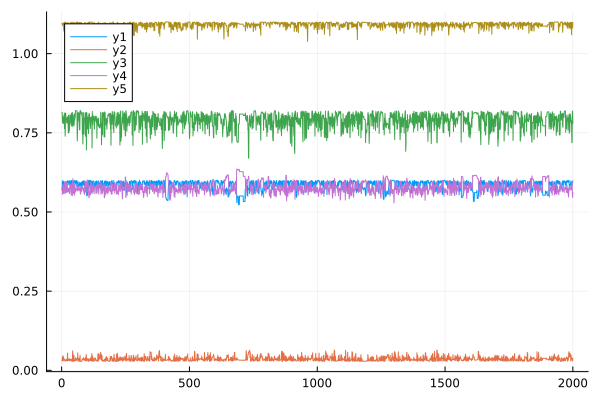

In [17]:
plot(Matrix(chain_wlwl_nomarg[:, 3:7]))

In [18]:
plot(Matrix(chain_wlwl_num[:, 3:7]))

LoadError: BoundsError: attempt to access data frame with 0 columns at index [3:7]

In [ ]:
plot(Matrix(chain_gcgc_nomarg[:, 3:7]))

In [ ]:
plot(Matrix(chain_gcgc_num[:, 3:7]))

In [ ]:
plot(Matrix(chain_gcgc_ana[:, 3:7]))

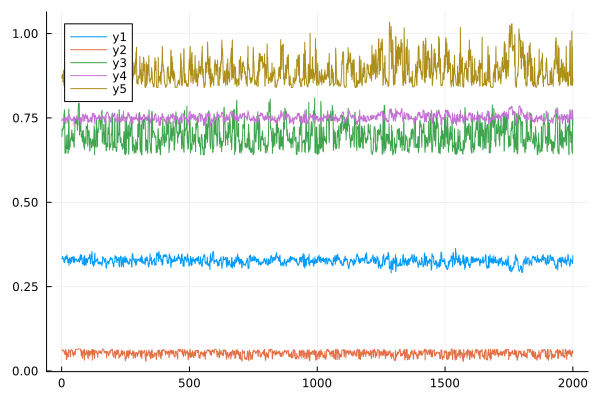

In [19]:
plot(Matrix(chain_3x2_nomarg[:, 3:7]))

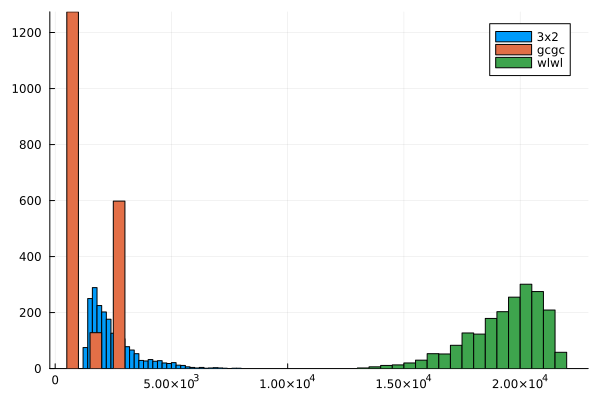

: 

In [20]:
histogram(xs_3x2, label="3x2")	
histogram!(xs_gcgc, label="gcgc")
histogram!(xs_wlwl, label="wlwl")